# Problem formulation


The machine learning problem that I will solve is song prediction, given inputs of audio files. Songs are divided into two classes: Harry Potter, Star Wars. The dataset is comprised of audio recordings where participants were asked to hum or whistle to a variety of songs.

This is a binary classification problem, as there are only two classes to predict. Therefore, it is fairly straight forward to train a model and test it. However, this problem is challenging and interesting, as features must be extracted from the audio files, and the correct validation techniques must be used to ascertain no biases.

# Machine Learning pipeline

# **Input and Output:**
The input to the pipeline is hum and whistle audio files (and their filenames), and the output is a prediction on whether the inputted audio file belongs to the Potter or StarWars class. The machine learning model outputs "True" for Potter, and "False" for StarWars. 

# **Preprocessing:**
After the file names are inputted, a dataframe is built storing the file ID, interpretation (hum/whistle), number (e.g. hum_1 or hum_2), and song (StarWars/Potter). The file names are used as an index for this dataframe. Some preprocessing steps are used to create the dataframe. For example, sample "S55" was removed due to the file name adding complexity to the string processing used to construct the dataframe. Also, file names which contained spaces and led to Index Errors were also removed. Once the dataframe was constructed, the song labels and interpretation columns were processed to obtain uniformity. For example, changing "[StarWars]" to "StarWars". This was so that it could remain a binary classification problem.

# **Feature Extraction:**
Feature extraction then took place, to extract eight features from the audio files: power, pitch_mean, pitch_std, voiced_fr, tempo, mean, standard_dev, inter_quartile_range. All of these features provide important information on audio files, thus can be very valuable to train the model with.

# **Feature Selection:**
The most important features were selected in this stage (based on scores of various models, and confusion matrices). The most important features were: pitch_mean, pitch_std, and tempo.

# **Transformations & Modelling:**
A machine learning algorithm was trained in this stage, which took the normalised selected features as input to make predictions. Normalisation of the data was achieved through using StandardScaler.



# Transformation stage


# **Feature Extraction:**
Feature extraction was implemented using a similar approach to the Starter Kit  template. A getXy function was created, which took files and a labels file (dataframe) as input. Various methods from the librosa library was used to extract features from the dataset. The features which were extracted are stated in section 3. The output of the getXy function was an X numpy array containing 8 predictors for each sample, and a label array y, which contained a True (Potter) or False (StarWars) label.

# **Normalisation:**
The data was normalised before being inputted to the model. This was achieved through using sklearn's StandardScaler, which uses a z-score normalisation method. However, data leakage is a very common problem in this stage if you use cross-validation to score the model. This is because the cross-validation splits the data 4:1, and repeats this process with different folds (5 fold cross-validation). If we normalise all of the training data and perform cross validation, the StandardScaler will also fit the validation set resulting in a data leakage. To overcome this problem, a pipeline was created containing the scaler and the model. This was inputted into the GridSearchCV to cross-validate with the training data being scaled only.

# Modelling

Two common classification machine learning models were used to classify the samples: KNeighbours and Logistic Regression. 

**KNeighbours Classifier:** This is a simple algorithm which uses the k-nearest neighbours of the given sample to predict which class it belongs to. For example, if k = 3, two nearest neighbours belong to "Potter", and one neighbour belongs to "StarWars" the sample should be classified as "Potter". Understandably, selecting an appropriate value for k is heavily dependent on the dataset. In my approach, I will be using GridSearchCV to tune this parameter.

**Logistic Regression:** Logistic Regression produces probabilities that a sample belongs to the class 1. As a result, it only produces values between 0-1. This probability can then be used to decide whether a sample would belong to "Potter" or "Star Wars" using the logistic function.

# Methodology


Models are trained using a nested cross-validation approach. This accomplishes both hyperparameter tuning, and model selection. Firstly, the data is split into a training and test set. The test set is left untouched for now. Secondly,  a pipeline is built, containing a scaler, and classifier (to ensure no data leakage in scaling). GridSearchCV is then used in an "inner cross-validation loop" for the hyperparameter tuning, this is computed for each iteration of the "outer cross-validation loop". The average accuracy over the different test folds are then printed and used as a score. The best model is chosen with regards to the score it achieves on the outer loop. 

This score is compared for the two algorithms (KNeighbours, Logistic Regression), and the one with the higher score is chosen to be the final model to predict the test data with. Training scores are also taken into consideration so we can see if the models are overfitting.

The final model is then fit with the entirety of the X_train, y_train data so that it has more samples to learn from. The final training accuracy is obtained here. This model is then used to score X_test and y_test, and come up with a final test accuracy of the model, and a classification report.

Accuracy is a good metric to use, as the classes are balanced.

# Dataset



The dataset is composed of all the audio files from part 1 and part 2 of Harry Potter and Star Wars. Samples "S55" is removed to make string processing easier - this shouldn't have much impact on the training of the model, as it's only removing 4 samples. Samples causing IndexErrors are removed next. Overall, 10 samples are removed in total. A dataframe is built up with this information, and values in the "song" column are renamed so that there are only two classes: Potter and StarWars. Before doing this step there were 10+ different labels due to misspelling in the file names (StartWars, [StarWars], etc.). Interpretations (hum/whistle) are also standardised into two classes for good measure. 

The feature extraction extracts 8 features from the audio files. Feature selection then selects three of these features: pitch_mean, pitch_std, and tempo and adds them to the X array. The y array consists of the corresponding labels. This is the data which is used to create/validate the models.

Some feature visualisations are provided. These show that there could be samples classed as "outliers" in the features data. I previously removed outliers using the DBSCAN algorithm, and my model accuracy increased drastically. If I was to remove all of these outliers, I would obtain a high accuracy, but when deploying this model, there would be a higher rejection rate for people with out of tune voices. My approach to this machine learning problem is that anyone should be able to input their audio file, whether they hum/whistle badly or not, and my model should be able to predict correctly. As a result, I have kept these outliers, and accepted the fact that my model accuracy may be lower than it could be, but also more inclusive.

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


Import data...

In [ ]:
hp_sw_original = hp1 + sw1 + hp2 + sw2


for file in hp_sw_original:
  print(file.split("/")[8])

In [ ]:
# Remove the "S55" sample.

hp_sw = []

for l in hp_sw_original:
  if "S55" not in l:
    hp_sw.append(l)

In [ ]:
len(hp_sw)

820

In [ ]:
# Table with information about the audio files.

# Files which cause an IndexError (mostly files with spaces) are not included.

hw_table = []
index_error_files = []  # contains all the files which result in index error

for file in hp_sw:
  try:
    # Build the dataframe
    file_name = file.split('/')[-1]
    participant_ID = file.split('/')[-1].split('_')[0]
    interpretation_type = file.split('/')[-1].split('_')[1]
    interpretation_number = file.split('/')[-1].split('_')[2]
    song = file.split('/')[-1].split('_')[3].split('.')[0]
    hw_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])
  except IndexError:
    index_error_files.append(file) # Append the file that caused index error
    continue

# hw_table

In [ ]:
hp_sw = [x for x in hp_sw if x not in index_error_files] # remove the files that cause index error

In [ ]:
len(hw_table)

814

In [ ]:
hw_df = pd.DataFrame(hw_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
hw_df

,participant,interpretation,number,song
file_id,,,,
S1_hum_2_Potter.wav,S1,hum,2,Potter
S3_hum_2_Potter.wav,S3,hum,2,Potter
S3_hum_1_Potter.wav,S3,hum,1,Potter
S1_whistle_2_Potter.wav,S1,whistle,2,Potter
S2_hum_2_Potter.wav,S2,hum,2,Potter
...,...,...,...,...
S219_hum_4_StarWars.wav,S219,hum,4,StarWars
S221_hum_1_StartWars.wav,S221,hum,1,StartWars
S221_hum_2_StarWars.wav,S221,hum,2,StarWars


In [ ]:
# Make sure all the interpretations are uniform. "hum" for hums, and "whistle" for whistles

interpretations = hw_df["interpretation"]
new_inter = []
for s in interpretations:
  if "Hum" in s or "hum" in s:
    new_inter.append("hum")
  else:
    new_inter.append("whistle")

In [ ]:
# Make sure all the labels uniform. "Potter" for Potter, and "StarWars" for Star Wars

songs = hw_df["song"]
new_songs = []
for s in songs:
  if "Potter" in s or "potter" in s or "Harry" in s or "harry" in s:
    new_songs.append("Potter")
  else:
    new_songs.append("StarWars")


In [ ]:
# There are many different labels, when there should only be two in each column.

print("Interpretations:")
print(hw_df["interpretation"].value_counts())
print()
print("Song labels:")
print(hw_df["song"].value_counts())

Interpretations:
hum        561
whistle    221
Hum         20
Whistle      8
whisle       2
whislte      1
hum2         1
Name: interpretation, dtype: int64

Song labels:
Potter           344
StarWars         323
[Potter]          34
[StarWars]        29
Starwars          21
potter            13
starwars           7
Potter             4
[potter]           4
Imperial           3
[STARWARS]         2
Star wars          2
(potter)           2
star               2
star wars          2
StarsWars          2
[ Star Wars ]      2
(starwars)         2
starwar            2
[Starwars]         2
Harry              2
[StarWars]         2
[Potter]           2
March              1
[StatWars]         1
harry potter       1
Potterwav          1
imperial           1
StartWars          1
Name: song, dtype: int64


In [ ]:
# Replace interpretations and song labels with processed values
hw_df["interpretation"] = pd.Series(new_inter).values
hw_df["song"] = pd.Series(new_songs).values

In [ ]:
# That's better!
hw_df["song"].value_counts()

StarWars    407
Potter      407
Name: song, dtype: int64

In [ ]:
hw_df["interpretation"].value_counts()

hum        582
whistle    232
Name: interpretation, dtype: int64

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
import scipy.stats

def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['song']=='Potter'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    freqs = np.fft.fftfreq(x.size)
          
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag) # extract voiced fr
    tempo = librosa.beat.tempo(x)[0] # Extract tempo
    mean = np.mean(freqs) # extract mean freqs
    standard_dev = np.std(freqs) # extract standard deviation freqs
    inter_quartile_range = scipy.stats.iqr(freqs) # extract iqr of freqs

    # Extract MFCC - not used in final implementation 
    # xi = []
    # mfcc = librosa.feature.mfcc(x, n_mfcc=13, sr=fs)
    # for c in mfcc:
    #   xi.append(c.mean())

    xi = [power, pitch_mean, pitch_std, voiced_fr, tempo, mean, standard_dev, inter_quartile_range]

    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
X,y = getXy(hp_sw, labels_file=hw_df, scale_audio=True, onlySingleDigit=True)

In [ ]:
X = np.load("X_values2_extras.npy")
y = np.load("y_values2_extras.npy")

In [ ]:
print('The shape of X is', X.shape)
print('The shape of y is', y.shape)
print('The first value in the labels vector is', y[0])
print("Potter is True, StarWars is False")

The shape of X is (814, 8)
The shape of y is (814,)
The first value in the labels vector is True
Potter is True, StarWars is False


In [ ]:
# After experimenting, only these 3 features are the most important.
# Feature selection

feature_list = []

for features in X:
  feature_list.append([features[1], features[2], features[4]])

X = feature_list

print(feature_list[0])


[107.62876897985909, 14.832539463078726, 86.1328125]


Text(0.5, 0, 'tempo')

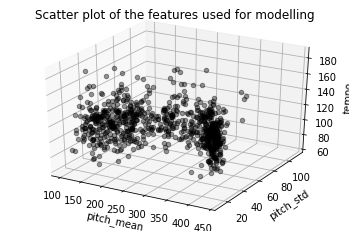

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for e in X:
  ax.scatter3D(e[0], e[1], e[2], alpha=0.4, c="k")
ax.set_title("Scatter plot of the features used for modelling")
ax.set_xlabel('pitch_mean')
ax.set_ylabel('pitch_std')
ax.set_zlabel('tempo')

Text(0, 0.5, 'Frequency')

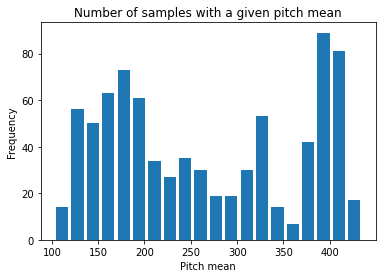

In [ ]:
import matplotlib.pyplot as plt

pitch_mean = []

for e in X:
    pitch_mean.append(e[0])

#len(pitch_mean)
plt.hist(pitch_mean, bins=20, rwidth=0.8)
plt.title("Number of samples with a given pitch mean")
plt.xlabel("Pitch mean")
plt.ylabel("Frequency")

There are no outliers to remove regarding pitch mean.

Text(0, 0.5, 'Frequency')

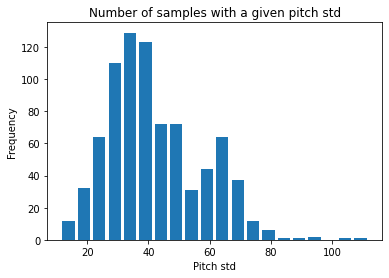

In [ ]:
pitch_std = []

for e in X:
    pitch_std.append(e[1])

plt.hist(pitch_std, bins=20, rwidth=0.8)
plt.title("Number of samples with a given pitch std")
plt.xlabel("Pitch std")
plt.ylabel("Frequency")

This data has some samples with a pitch standard deviation of greater than 80. These could be considered as outliers and may reduce the performance of the model.

Text(0, 0.5, 'Frequency')

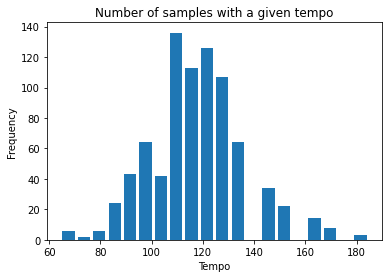

In [ ]:
pitch_tempo = []

for e in X:
    pitch_tempo.append(e[2])

plt.hist(pitch_tempo, bins=20, rwidth=0.8)
plt.title("Number of samples with a given tempo")
plt.xlabel("Tempo")
plt.ylabel("Frequency")

This data follows a normal distribution. Samples outside of 3 standard deviations could be removed in outlier detection. However, I have decided to keep them in.

# Results

After training and cross validating, the KNeighborsClassifier performed better than the LogisticRegression. The training accuracy of the best KNeighborsClassifier was 0.74, compared to LogisticRegression's 0.57. The averaged cross validation accuracy of the KNeighboursClassifier was 0.67, compared to 0.58 of the LogisticRegression. Finally, the test accuracy of the KNeighboursClassifier was 0.64. Test accuracy of the LogisticRegression wasn't calculated as we are not choosing this model based on its other scores, so there is no reason to predict the test set when we have a better model available.

There are a plethora of reasons explaining why LogisticRegression could have performed worse than the KNeighboursClassifier. One likely reason is that the 2 classes are not linearly separable, so the algorithm struggles to classify. On the other hand, KNeighbours is non-parametric and uses distance measures, so it doesn't need to calculate a boundary. Another reason could be due to the hyperparameter tuning. In my implementation, I used many different hyperparameter tuning methods for KNeighbours (n_neighbours, metric, weights), whereas for LogisticRegression I only tuned the C parameter.

In any case, the accuracies obtained by both of these algorithms are not very high (as 50% is the worst for a binary classification problem). This could be due to the presence of outliers, sub-optimal feature extraction/selection, and overfitting on the training set.

In [ ]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import seaborn as sn
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [ ]:
inner_cross = KFold(n_splits=3, shuffle=True, random_state=5)

neigh_pipe = Pipeline([("scalar", StandardScaler()),
                     ("neigh", KNeighborsClassifier())])

parameters = {
    "neigh__n_neighbors": [5, 11, 15, 25, 35],
    "neigh__metric": ["manhattan", "euclidean"],
    "neigh__weights": ["distance", "uniform"]
}

gridSearch = GridSearchCV(estimator=neigh_pipe,
                          param_grid=parameters,
                          cv=inner_cross,
                          refit=True)

outer_cross = KFold(n_splits=10, shuffle=True, random_state=5)
score = cross_val_score(gridSearch, X_train, y_train, cv=outer_cross)
print("Cross Validation Score: ", score.mean())

Cross Validation Score:  0.6727972027972028


In [ ]:
gridSearch.fit(X_train, y_train)
print("Train accuracy: ", gridSearch.score(X_train, y_train))
print("Test accuracy: ", gridSearch.score(X_test, y_test))

print(classification_report(y_test, gridSearch.predict(X_test)))

Train accuracy:  0.7465437788018433
Test accuracy:  0.6441717791411042
              precision    recall  f1-score   support

       False       0.66      0.59      0.62        81
        True       0.63      0.70      0.66        82

    accuracy                           0.64       163
   macro avg       0.65      0.64      0.64       163
weighted avg       0.65      0.64      0.64       163



In [ ]:
inner_cross = KFold(n_splits=3, shuffle=True, random_state=5)

lgr_pipe = Pipeline([("scalar", StandardScaler()),
                     ("lr", LogisticRegression())])

params = {
    "lr__C": np.logspace(-3,3,20),
}

gridSearch_lgr = GridSearchCV(estimator=lgr_pipe,
                          param_grid=params,
                          cv=inner_cross,
                          refit=True)

outer_cross = KFold(n_splits=10, shuffle=True, random_state=5)
score = cross_val_score(gridSearch_lgr, X_train, y_train, cv=outer_cross)
print("Score: ", score.mean())

Score:  0.5852680652680653


In [ ]:
gridSearch_lgr.fit(X_train, y_train)
gridSearch_lgr.score(X_train, y_train)

0.5775729646697388

# Conclusions

In conclusion, it can be said that KNeighbours performed better on this dataset compared to LogisticRegression. However, it is also clear that the accuracy of the algorithms could probably be improved. To accomplish this, different features should be extracted, (MFCC's didn't improve the accuracy) or different features should be selected to find the most optimal. To test the idea that LogisticRegression performed badly, we could train an SVM and see how it performs on this data, as SVM's are able to handle more complex decision boundaries. If we want a more strict model which is able to predict more accurately, we could also remove outliers in the future.